In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from scipy.optimize import curve_fit
from scipy import stats
from scipy import optimize
from scipy.stats import f

1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

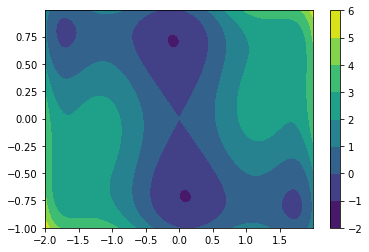

In [2]:
def six_hump_camelback(params):
    x = params[0]
    y = params[1]

    z = (4 - 2.1*(x**2) + (x**4)/3)*(x**2) + x*y + (4*(y**2) - 4)*(y**2)
    return z

x = np.arange(-2,2,0.01)
y = np.arange(-1,1,0.01)
xx, yy = np.meshgrid(x, y, sparse=True)
z = six_hump_camelback((xx,yy))
plt.contourf(x, y, z)
plt.colorbar()
plt.show()

In [3]:
starting_points = [ [-0.1, 0.7], [0.1, -0.7], [0, 0]] # first 2 values are decided after analysing the image.

for starting_point in starting_points:
    result = optimize.basinhopping(six_hump_camelback, starting_point, niter = 200)
    print("\nStarting Point: ", starting_point)
    print("Function Value: ", result.fun)
    print("[x, y]: ", result.x)
    
print("\nThere are 2 different global minima of the function as we can see from the plotting.")
print("\nWith the initial guess of (𝑥,𝑦)=(0,0) global minima is found the same as the other 2 global minima.")


Starting Point:  [-0.1, 0.7]
Function Value:  -1.0316284534898772
[x, y]:  [-0.08984201  0.7126564 ]

Starting Point:  [0.1, -0.7]
Function Value:  -1.0316284534898774
[x, y]:  [ 0.08984201 -0.7126564 ]

Starting Point:  [0, 0]
Function Value:  -1.0316284534898772
[x, y]:  [-0.08984202  0.7126564 ]

There are 2 different global minima of the function as we can see from the plotting.

With the initial guess of (𝑥,𝑦)=(0,0) global minima is found the same as the other 2 global minima.


2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

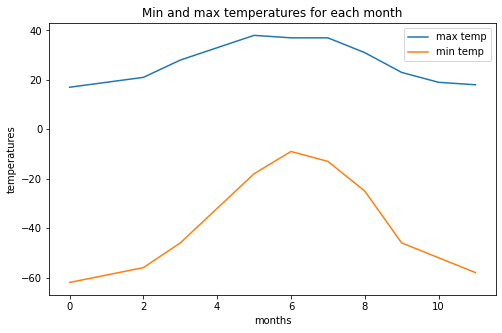

In [4]:
max_temp = [17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18]
min_temp = [-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58]
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(max_temp, label = "max temp")
plt.plot(min_temp, label = "min temp")
plt.ylabel("temperatures")
plt.xlabel("months")
plt.title("Min and max temperatures for each month")
plt.legend()
plt.show()


In [5]:
def gaussian_func(x, scale, mean, sigma, d):
    return scale * np.exp( -(x - mean)**2 / (2 * sigma**2)) + d

mean_max = sum(np.arange(12) * max_temp) / sum(max_temp)
sigma_max = np.sqrt(sum(max_temp * (np.arange(12) - mean_max)**2) / sum(max_temp))

mean_min = sum(np.arange(12) * min_temp) / sum(min_temp)
sigma_min = np.sqrt(sum(min_temp * (np.arange(12) - mean_min)**2) / sum(min_temp))

popt_max, pcov_max = optimize.curve_fit(gaussian_func, np.arange(12), max_temp, p0 = [max(max_temp), mean_max, sigma_max, 0])
print("popt max: ", popt_max, "\n")
print("pcov max:\n", pcov_max, "\n\n\n")

popt_min, pcov_min = optimize.curve_fit(gaussian_func, np.arange(12), min_temp, p0 = [max(min_temp), mean_min, sigma_min, 0])
print("popt min: ", popt_min, "\n")
print("pcov min:\n", pcov_min)

popt max:  [23.09207141  5.73581557  2.29443164 15.77934501] 

pcov max:
 [[ 1.32867535e+00 -1.60423832e-03  1.01480460e-01 -1.08340989e+00]
 [-1.60423832e-03  6.31514259e-03 -2.12233078e-04  1.91648216e-03]
 [ 1.01480460e-01 -2.12233078e-04  2.75441452e-02 -1.70935422e-01]
 [-1.08340989e+00  1.91648216e-03 -1.70935422e-01  1.38433748e+00]] 



popt min:  [ 52.64929244   6.16452594   1.97590023 -61.32093749] 

pcov min:
 [[ 1.96936391e+00 -8.73505990e-04  2.27187852e-02 -1.05130554e+00]
 [-8.73505990e-04  2.22850049e-03 -4.92554928e-05  1.09102020e-03]
 [ 2.27187852e-02 -4.92554928e-05  5.77327917e-03 -7.06520995e-02]
 [-1.05130554e+00  1.09102020e-03 -7.06520995e-02  1.41330971e+00]]


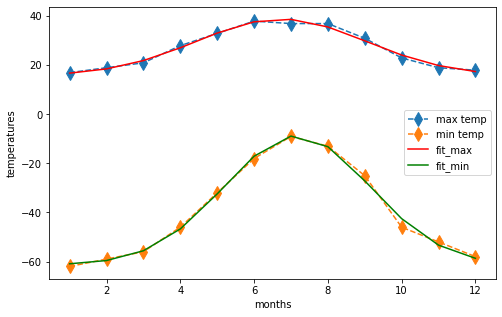

The parameters found are meaningful and, when we also check the plot, the fit is satisfactory.
The time shift is not the same for min and max temperatures.


In [6]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.ylabel("temperatures")
plt.xlabel("months")

plt.plot(months, max_temp, linestyle = "--", marker="d", markersize = 10, label = "max temp")
plt.plot(months, min_temp, linestyle = "--", marker="d", markersize = 10, label = "min temp")
plt.plot(months, gaussian_func(np.linspace(0, 11, 12), *popt_max), color = "red", label = "fit_max")
plt.plot(months, gaussian_func(np.linspace(0, 11, 12), *popt_min), color = "green", label = "fit_min")
plt.legend()
plt.show()

print("The parameters found are meaningful and, when we also check the plot, the fit is satisfactory.")
print("The time shift is not the same for min and max temperatures.")

3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

In [7]:
data = pd.DataFrame(dict(pd.read_pickle("residuals_261.pkl").item()))
data

,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
2,-7.200000,3.4
3,-4.150000,8.4
4,-6.590000,1.7
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


In [8]:
data = data.loc[abs(data["residuals"]) < 2]
data

,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
8,-0.042857,3.3
9,0.128571,5.3
10,0.085714,15.0
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


Parameters:  [ 1.26651516e+03 -8.51374040e-02  2.14150668e-01  3.95108436e+01]


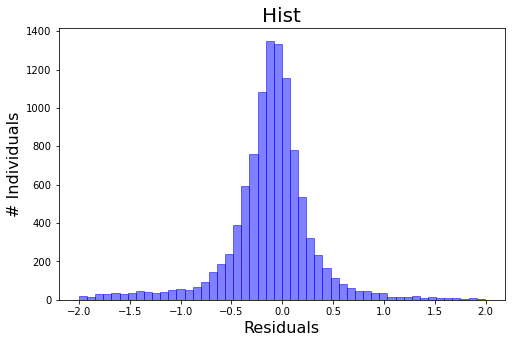

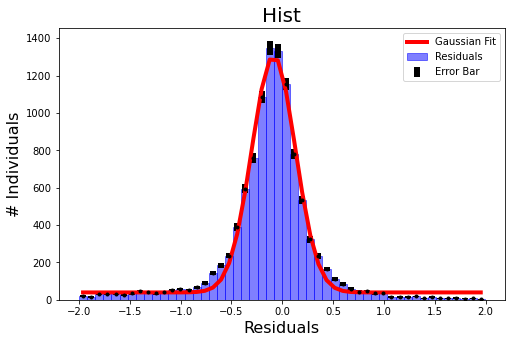

In [9]:
residuals = data["residuals"]

fig, ax = plt.subplots(figsize=(8, 5))
ax.set_title("Hist", fontsize = 20)
ax.set_xlabel("Residuals", fontsize = 16)
ax.set_ylabel("# Individuals", fontsize = 16)
y, bins, _ = plt.hist(residuals, bins = 50, color = "blue", alpha = 0.5, edgecolor = "blue", label = 'Residuals')

fig, ax = plt.subplots(figsize=(8, 5))
ax.set_title("Hist", fontsize = 20)
ax.set_xlabel("Residuals", fontsize = 16)
ax.set_ylabel("# Individuals", fontsize = 16)
plt.hist(residuals, bins = 50, color = 'blue', alpha = 0.5, edgecolor = "blue", label = 'Residuals')

sigma_y = np.sqrt(np.abs(y))
bin_centers = (bins[:-1] + bins[1:]) / 2

# not very clear error bar
ax.errorbar(x = bin_centers, y = y, yerr = sigma_y, elinewidth = 6, fmt='.k', color = "black", linestyle = "None", label = "Error Bar")

mean, sigma = stats.norm.fit(y)
popt, pcov = optimize.curve_fit(gaussian_func, bin_centers, y)
print("Parameters: ", popt)
redefined_y = gaussian_func(bin_centers, *popt)
ax.plot(bin_centers, redefined_y, "red", linewidth = 4, label = "Gaussian Fit")
plt.legend()
plt.show()

In [10]:
# goodness-of-fit test
gaussian_fit = gaussian_func(bin_centers ,*tuple(popt))
ndof = len(bin_centers) - 1
chi2 = np.sum(((y - gaussian_fit)**2) / ndof)
p = 1. - stats.chi2.cdf(chi2, ndof)

print("chi2 :", chi2)
print("p value :", p)

print("P value is ", p, ", which is smaller than 0.05. The fit is not satisfactory")

chi2 : 1380.4726698229942
p value : 0.0
P value is  0.0 , which is smaller than 0.05. The fit is not satisfactory


4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is motivated.

In [11]:
munich_data = np.loadtxt("munich_temperatures_average_with_bad_data.txt")
data = pd.DataFrame(munich_data, columns=["year","temperature"])
data

,year,temperature
0,1995.00274,0.944444
1,1995.00548,-1.611110
2,1995.00821,-3.555560
3,1995.01095,-9.833330
4,1995.01369,-10.222200
...,...,...
6674,2013.27379,7.333330
6675,2013.27652,10.000000
6676,2013.27926,10.555600
6677,2013.28200,8.944440


In [12]:
data = data[(data['year'] >= 2008) & (data['year'] < 2012)]
data

,year,temperature
4748,2008.00274,-2.94444
4749,2008.00548,-2.66667
4750,2008.00821,-2.66667
4751,2008.01095,-2.00000
4752,2008.01369,-1.94444
...,...,...
6204,2011.98836,3.44444
6205,2011.99110,1.27778
6206,2011.99384,2.88889
6207,2011.99658,1.83333


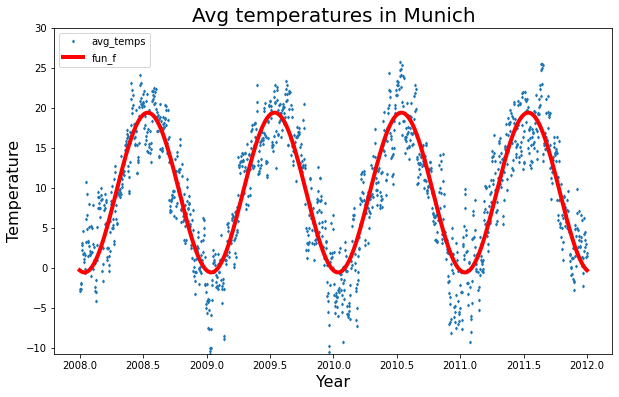

In [13]:
def fun_f(t, a, b, c):
    return a * np.cos(2 * np.pi * t + b) + c
popt_f, pcov_f = optimize.curve_fit(fun_f, data["year"], data["temperature"], p0 = [1, 1, np.mean(data["temperature"])])
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title("Avg temperatures in Munich", fontsize = 20)
ax.set_xlabel("Year", fontsize = 16)
ax.set_ylabel("Temperature", fontsize = 16)
plt.plot(data["year"], data["temperature"], marker="d", markersize = 2, label = "avg_temps", linestyle = "None")
plt.ylim((min(data['temperature']), 30))

x = np.linspace(2008, 2012, len(data["temperature"]))
y = fun_f(x, *popt_f)
plt.plot(x, y, color = "red", linewidth = 4, label = "fun_f")
plt.legend()
plt.show()

In [14]:
print("Popt :", popt_f)
print("Cov matrix :", pcov_f, "\n")
print("Avg. Temperature :", popt_f[2])
print("Typical daily average value predicted by the model for the coldest time :", popt_f[2] + popt_f[0])
print("Typical daily average value predicted by the model for the hottest time :", popt_f[2] - popt_f[0])

Popt : [-9.98813369  6.04983771  9.38411487]
Cov matrix : [[ 3.22599218e-02 -1.58736555e-07 -5.53390302e-08]
 [-1.58736555e-07  3.23393388e-04 -2.22774352e-08]
 [-5.53390302e-08 -2.22774352e-08  1.61303440e-02]] 

Avg. Temperature : 9.384114873388999
Typical daily average value predicted by the model for the coldest time : -0.6040188131223037
Typical daily average value predicted by the model for the hottest time : 19.3722485599003


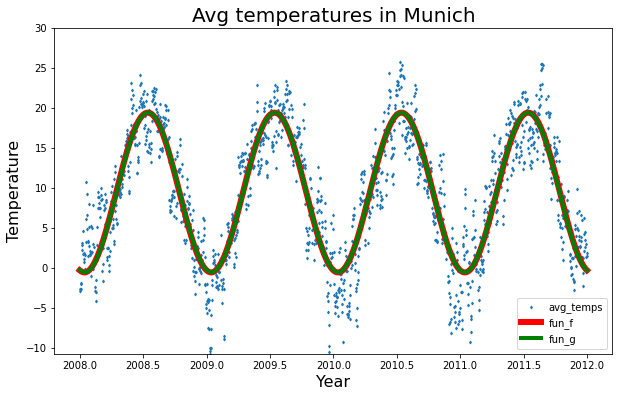

fun_f and fun_g are at the exact same plot


In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title("Avg temperatures in Munich", fontsize = 20)
ax.set_xlabel("Year", fontsize = 16)
ax.set_ylabel("Temperature", fontsize = 16)
plt.plot(data["year"], data["temperature"], marker="d", markersize = 2, label = "avg_temps", linestyle = "None")
plt.ylim((min(data["temperature"]), 30))
plt.plot(x, y, color = "red", linewidth = 6, label = "fun_f")

def fun_g(t, a, b, c, d):
    return a * np.cos(2 * np.pi * t * b + c) + d

# In this function, b is the shift argument that lets function to set starting point correctly.
# Here, instead of taking "t" as 0 in every year, with the help of "b", "t" may get different values

popt_g, pcov_g = optimize.curve_fit(fun_g, data["year"], data['temperature'])
y_g = fun_g(x, *popt_g)

plt.plot(x, y_g, color="green", linewidth = 4, label = "fun_g")
plt.legend()
plt.show()

print("fun_f and fun_g are at the exact same plot")

In [16]:
ssr_1 = np.sum((y - data["temperature"])**2)
print("SSR_1 :", ssr_1)
ssr_2 = np.sum((y_g - data["temperature"])**2)
print("SSR_2 :", ssr_2)

def Ftest(ssr_1, ssr_2, ndof_1, ndof_2, nbins, verbose=False):
    F = ((ssr_1 - ssr_2)/(ndof_2 - ndof_1)) / (ssr_2/(nbins - ndof_2))
    CL = 1. - f.cdf(F, ndof_2 - ndof_1, nbins - ndof_2)
    if verbose: print("CL: %.3f" % CL, ", additional parameter necessary:", "YES" if CL < 0.10 else "NO")
    return CL
cl_1_2 = Ftest(ssr_1, ssr_2, 2, 3, len(data["temperature"]), verbose=True)

print("\nUsing the function with 3 parameters is enough to approximate the data. Adding the 4th parameters does not create a noticable difference in the approximation.")

SSR_1 : 34343.64193708167
SSR_2 : 34344.17134450799
CL: 1.000 , additional parameter necessary: NO

Using the function with 3 parameters is enough to approximate the data. Adding the 4th parameters does not create a noticable difference in the approximation.
